In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
import warnings

# --- Basic Setup ---
warnings.filterwarnings("ignore")
# Check for available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 1. Define Data Distributions ---
# Initial distribution p₀ (a single Gaussian)
p0_mean = torch.tensor([-5.0, 0.0], device=device)
p0_cov = torch.tensor([[0.1, 0.0], [0.0, 1.2]], device=device)

# Target distribution p₁ (a mixture of two Gaussians)
p1_means = [
    torch.tensor([5.0, 3.0], device=device),
    torch.tensor([5.0, -3.0], device=device)
]
p1_covs = [
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device),
    torch.tensor([[0.1, 0.0], [0.0, 0.5]], device=device)
]
p1_weights = torch.tensor([0.5, 0.5], device=device)


def sample_p0(n_samples):
    """Sample from the initial distribution p₀."""
    dist = torch.distributions.MultivariateNormal(p0_mean, p0_cov)
    return dist.sample((n_samples,))

def sample_p1(n_samples):
    """Sample from the target mixture distribution p₁."""
    indices = torch.multinomial(p1_weights, n_samples, replacement=True)
    samples = torch.zeros(n_samples, 2, device=device)
    for i, (mean, cov) in enumerate(zip(p1_means, p1_covs)):
        mask = indices == i
        n_choice = mask.sum()
        if n_choice > 0:
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples[mask] = dist.sample((n_choice,))
    return samples

# --- 2. Define the Neural Network Model ---

class VectorFieldNet(nn.Module):
    """A simple MLP to approximate the vector field v(x, t)."""
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, t):
        t_reshaped = t.view(-1, 1)
        xt = torch.cat([x, t_reshaped], dim=1)
        return self.net(xt)


# --- 3. Train the Model ---

def train_flow_matching(model, epochs=5000, batch_size=2048, lr=1e-4):
    """Train the Flow Matching model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    print("Starting training...")

    for epoch in range(epochs):
        optimizer.zero_grad()

        x0 = sample_p0(batch_size)
        x1 = sample_p1(batch_size)
        t = torch.rand(batch_size, device=device)

        x_t = (1 - t.unsqueeze(1)) * x0 + t.unsqueeze(1) * x1
        u_t = x1 - x0

        v_pred = model(x_t, t)

        loss = loss_fn(v_pred, u_t)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    print("Training finished!")
    return model

# --- 4. ODE Solver (Heun's Method) ---

def solve_ode_heun(model, x0, num_steps):
    """Solve the ODE dx/dt = v(x,t) using Heun's method."""
    model.eval()
    trajectory = [x0.clone()]
    x = x0.clone()
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(num_steps):
            t = torch.full((x.size(0),), i * dt, device=device)
            v_pred = model(x, t)
            x_tilde = x + dt * v_pred
            t_next = torch.full((x.size(0),), (i + 1) * dt, device=device)
            v_tilde = model(x_tilde, t_next)
            x = x + 0.5 * dt * (v_pred + v_tilde)
            trajectory.append(x.clone())

    return torch.stack(trajectory).cpu().numpy()

# --- 5. Visualization Functions ---

def plot_training_pairs(ax, n_samples):
    """
    Plots the first subplot showing the random pairing of x0 and x1 during training.
    """
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'

    # Set subplot appearance
    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    # For pairing, the number of samples for x0 and x1 must be the same
    x0_samples = sample_p0(n_samples).cpu().numpy()
    x1_samples = sample_p1(n_samples).cpu().numpy()

    # Plot scatter distributions for p0 and p1
    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label='Target Dist. ($\mathbf{x_1}\sim\mathbf{p_1}$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label='Initial Dist. ($\mathbf{x_0}\sim\mathbf{p_0}$)')

    # Prepare lines connecting each x0 to its corresponding x1, colored like x0
    lines = np.array(list(zip(x0_samples, x1_samples)))
    lc = LineCollection(lines, colors=color_p0, linewidths=1.0, alpha=0.4)
    ax.add_collection(lc)

    # Set title and legend
    ax.set_title('Training Pairings', fontsize=32, fontweight='bold')
    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def create_subplot(ax, trajectories, x0_samples, x1_samples, num_steps):
    """
    Draws a single subplot for the sampling process.
    """
    color_p0 = '#5681EB'
    color_x0 = '#5681EB'
    color_p1 = '#DD6772'
    color_x1 = '#B1D2BB'

    # Set background to white and remove grid
    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    # Plot target and initial distributions
    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label='Target Dist. ($\mathbf{x_1}\sim\mathbf{p_1}$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label='Initial Dist. ($\mathbf{x_0}\sim\mathbf{p_0}$)')

    # Prepare for drawing trajectories
    lines = []
    colors = []
    start_rgba = np.array(to_rgba(color_x0))
    end_rgba = np.array(to_rgba(color_x1))
    for i in range(trajectories.shape[1]):
        points = trajectories[:, i, :]
        segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
        lines.extend(segments)
        t_fractions = np.linspace(0, 1, num_steps)
        segment_colors = (1 - t_fractions[:, np.newaxis]) * start_rgba + t_fractions[:, np.newaxis] * end_rgba
        colors.extend(segment_colors)

    lc = LineCollection(lines, colors=colors, linewidths=1.5, alpha=0.7)
    ax.add_collection(lc)

    # Set title to emphasize the number of sampling steps
    ax.set_title(f'Sampling: {num_steps} Steps', fontsize=32, fontweight='bold')

    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def visualize_trajectories(model, n_samples=300):
    """
    Creates a figure with three subplots, organized according to the new requirements.
    """
    # Set the sampling steps to plot to 1 and 5
    steps_to_plot = [1, 5]
    fig, axes = plt.subplots(1, 3, figsize=(28, 9))
    fig.patch.set_facecolor('white')

    # --- Subplot 1: Show training pairs ---
    plot_training_pairs(axes[0], n_samples)

    # --- Subplots 2 & 3: Show sampling process ---
    x0_samples_ode = sample_p0(n_samples).cpu().numpy()
    x1_samples_display = sample_p1(n_samples * 2).cpu().numpy()
    x0_tensor = torch.tensor(x0_samples_ode, device=device)

    # Iterate to plot subplots for sampling steps 1 and 5
    for ax, num_steps in zip(axes[1:], steps_to_plot):
        trajectories = solve_ode_heun(model, x0_tensor, num_steps)
        create_subplot(ax, trajectories, x0_samples_ode, x1_samples_display, num_steps)

    plt.tight_layout()
    plt.show()


Using device: cuda


Starting training...
Epoch [500/20000], Loss: 6.951099
Epoch [1000/20000], Loss: 3.205257
Epoch [1500/20000], Loss: 2.845645
Epoch [2000/20000], Loss: 2.568353
Epoch [2500/20000], Loss: 2.637310
Epoch [3000/20000], Loss: 2.519652
Epoch [3500/20000], Loss: 2.435904
Epoch [4000/20000], Loss: 2.337713
Epoch [4500/20000], Loss: 2.352448
Epoch [5000/20000], Loss: 2.519882
Epoch [5500/20000], Loss: 2.511277
Epoch [6000/20000], Loss: 2.441125
Epoch [6500/20000], Loss: 2.264587
Epoch [7000/20000], Loss: 2.247953
Epoch [7500/20000], Loss: 2.244523
Epoch [8000/20000], Loss: 2.279727
Epoch [8500/20000], Loss: 2.426984
Epoch [9000/20000], Loss: 2.336081
Epoch [9500/20000], Loss: 2.291853
Epoch [10000/20000], Loss: 2.346488
Epoch [10500/20000], Loss: 2.294713
Epoch [11000/20000], Loss: 2.394192
Epoch [11500/20000], Loss: 2.356746
Epoch [12000/20000], Loss: 2.356189
Epoch [12500/20000], Loss: 2.429489
Epoch [13000/20000], Loss: 2.340387
Epoch [13500/20000], Loss: 2.355474
Epoch [14000/20000], Loss: 

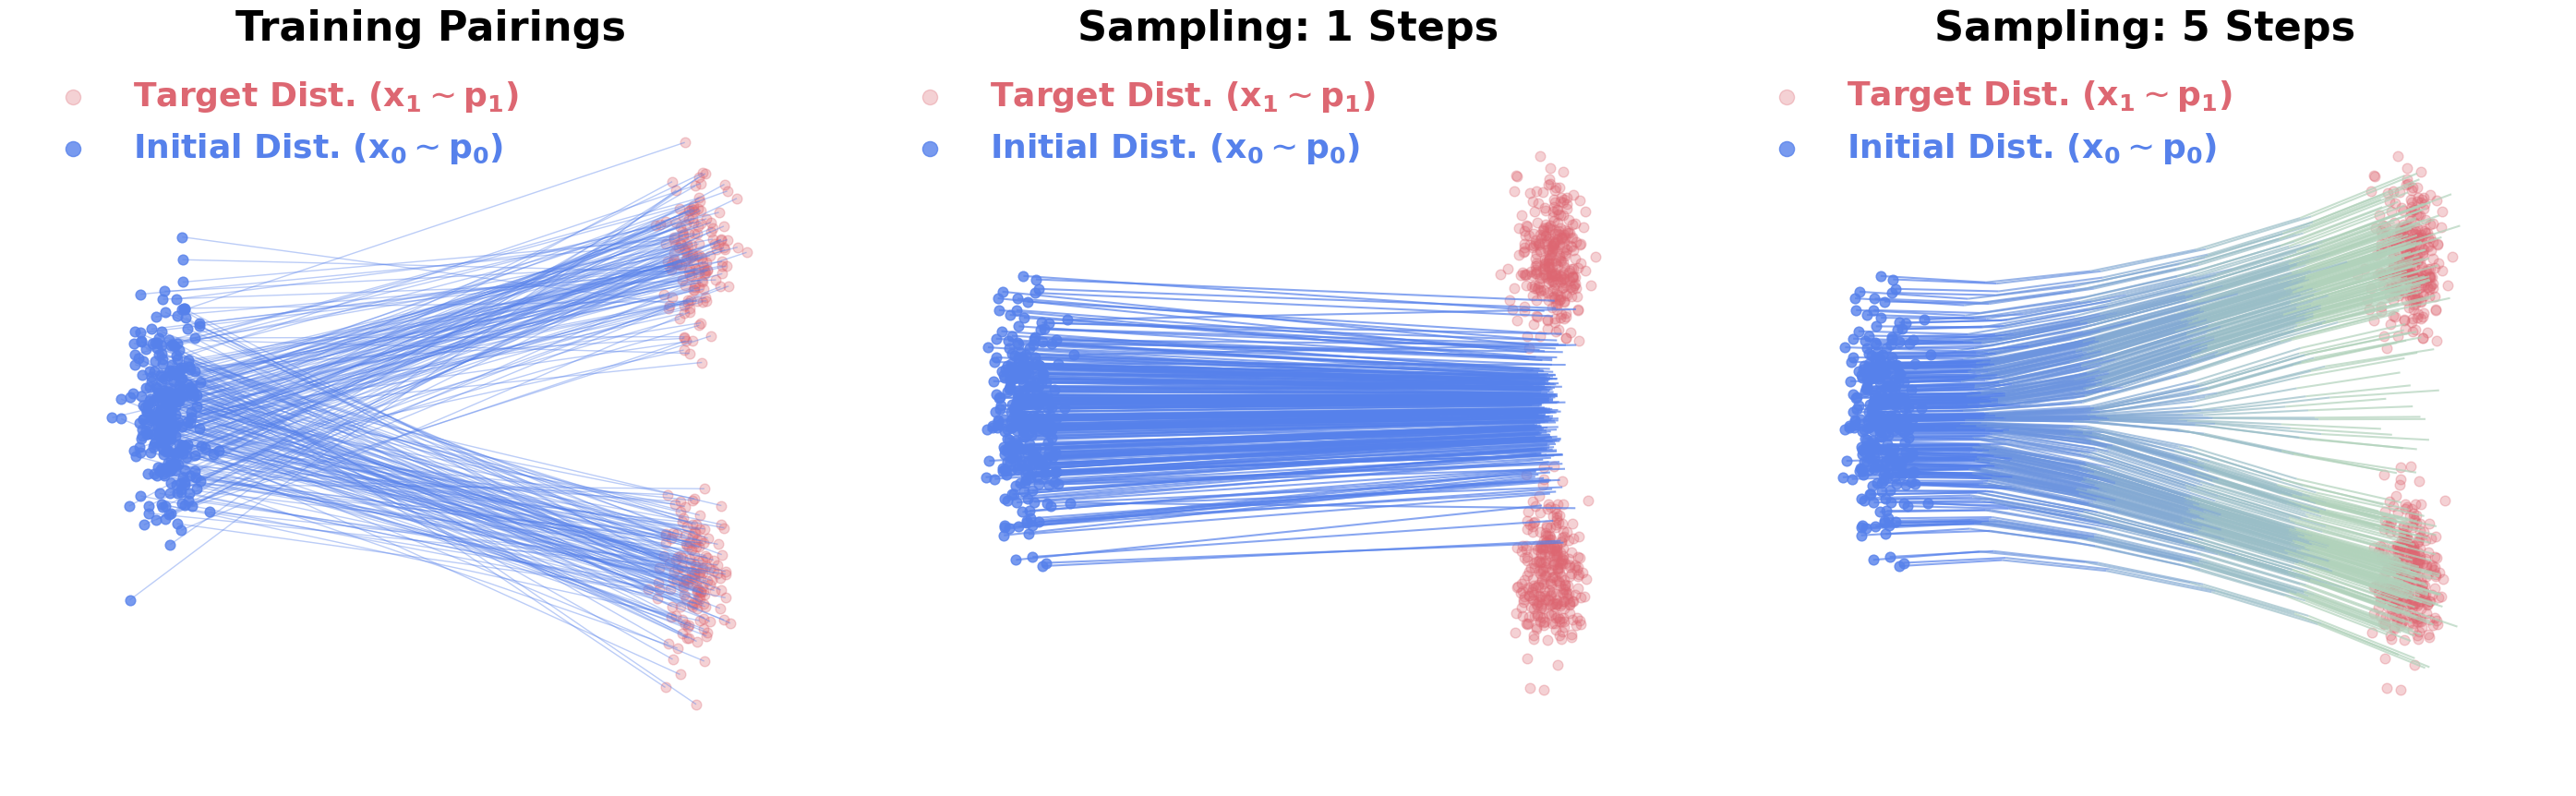

In [6]:
model = VectorFieldNet().to(device)
train_flow_matching(model, epochs=20000)
visualize_trajectories(model, n_samples=300)